In [21]:
import os
import warnings

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings(action='ignore')

In [22]:
TEST_SIZE = 0.4
FIG_SIZE = (8, 8)
RANDOM_STATE = 1
CORRELATION_THRESHOLD = 0.9
COLUMN_FOR_CLASSIFICATION = 'tfopwg_disp'

In [23]:
df = pd.read_csv('../data/TOI_2025.10.03_12.03.31.csv')
df.tail()

,rowid,toi,toipfx,tid,ctoi_alias,pl_pnum,tfopwg_disp,rastr,ra,raerr1,...,st_loggerr2,st_logglim,st_loggsymerr,st_rad,st_raderr1,st_raderr2,st_radlim,st_radsymerr,toi_created,rowupdate
7698,7699,995.01,995,317951248,3.179512e+08,1,FP,07h23m14.75s,110.811443,NaN,...,NaN,0,1,NaN,NaN,NaN,0,1,2019-07-24 15:58:33,2021-10-29 12:59:15
7699,7700,996.01,996,142918609,1.429186e+08,1,FP,07h57m23.99s,119.349948,NaN,...,NaN,0,1,2.050000,NaN,NaN,0,1,2019-07-24 15:58:33,2021-10-29 12:59:15
7700,7701,997.01,997,341729521,3.417295e+08,1,FP,08h05m16.69s,121.319521,NaN,...,-0.08,0,1,0.926261,0.045789,-0.045789,0,1,2019-07-24 15:58:33,2024-09-09 10:08:01
7701,7702,998.01,998,54390047,5.439005e+07,1,FP,07h53m16.69s,118.319555,NaN,...,-0.07,0,1,2.349860,0.091578,-0.091578,0,1,2019-07-24 15:58:33,2024-09-09 10:08:01
7702,7703,999.01,999,341186896,3.411869e+08,1,FP,07h55m27.38s,118.864086,NaN,...,-0.09,0,1,1.300000,0.050000,-0.050000,0,1,2019-07-24 15:58:33,2024-09-09 10:08:01


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7703 entries, 0 to 7702
Data columns (total 87 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rowid              7703 non-null   int64  
 1   toi                7703 non-null   float64
 2   toipfx             7703 non-null   int64  
 3   tid                7703 non-null   int64  
 4   ctoi_alias         7703 non-null   float64
 5   pl_pnum            7703 non-null   int64  
 6   tfopwg_disp        7703 non-null   object 
 7   rastr              7703 non-null   object 
 8   ra                 7703 non-null   float64
 9   raerr1             0 non-null      float64
 10  raerr2             0 non-null      float64
 11  decstr             7703 non-null   object 
 12  dec                7703 non-null   float64
 13  decerr1            0 non-null      float64
 14  decerr2            0 non-null      float64
 15  st_pmra            7569 non-null   float64
 16  st_pmraerr1        7569 

In [25]:
label_encoder = LabelEncoder()
df[COLUMN_FOR_CLASSIFICATION] = label_encoder.fit_transform(
    df[COLUMN_FOR_CLASSIFICATION]
)

class_names = label_encoder.classes_
for idx, cls in enumerate(class_names):
    print(idx, cls, df[df[COLUMN_FOR_CLASSIFICATION] == idx].shape[0])

0 APC 462
1 CP 684
2 FA 98
3 FP 1197
4 KP 583
5 PC 4679


In [26]:
# Remove all string columns
df = df.select_dtypes(include=[np.number])

# Remove all columns with null values
df = df.dropna(axis=1)

# Remove identifier columns
df = df.drop(
    columns=['rowid', 'pl_pnum', *list(df.filter(regex='err$|lim$', axis=1).columns)],
    axis=1,
)

In [27]:
corr_matrix = df.corr().abs()
upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)
)
to_drop = [
    column
    for column in upper_triangle.columns
    if any(upper_triangle[column] > CORRELATION_THRESHOLD)
]
df.drop(to_drop, axis=1, inplace=True)

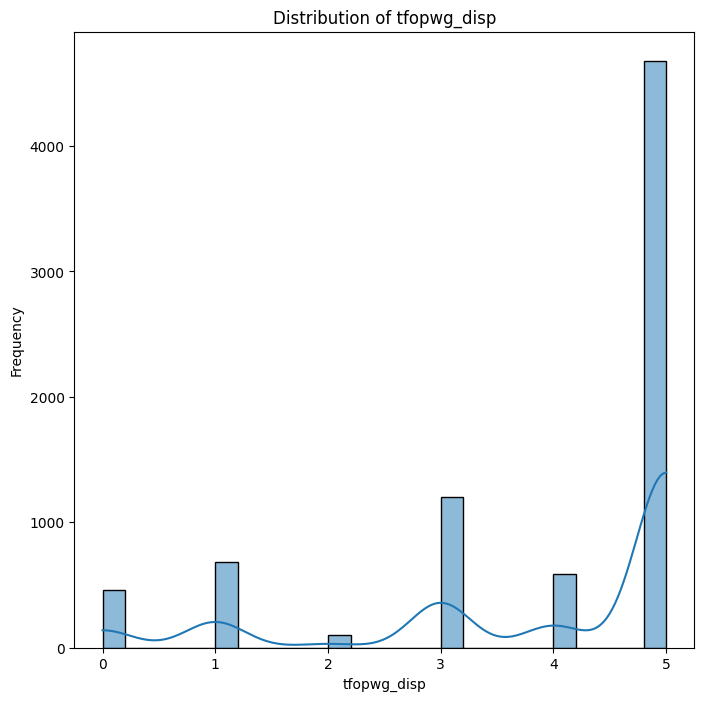

In [28]:
def plot_distribution(df: pd.DataFrame, col: str):
    plt.figure(figsize=FIG_SIZE)
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


plot_distribution(df, COLUMN_FOR_CLASSIFICATION)

<Axes: >

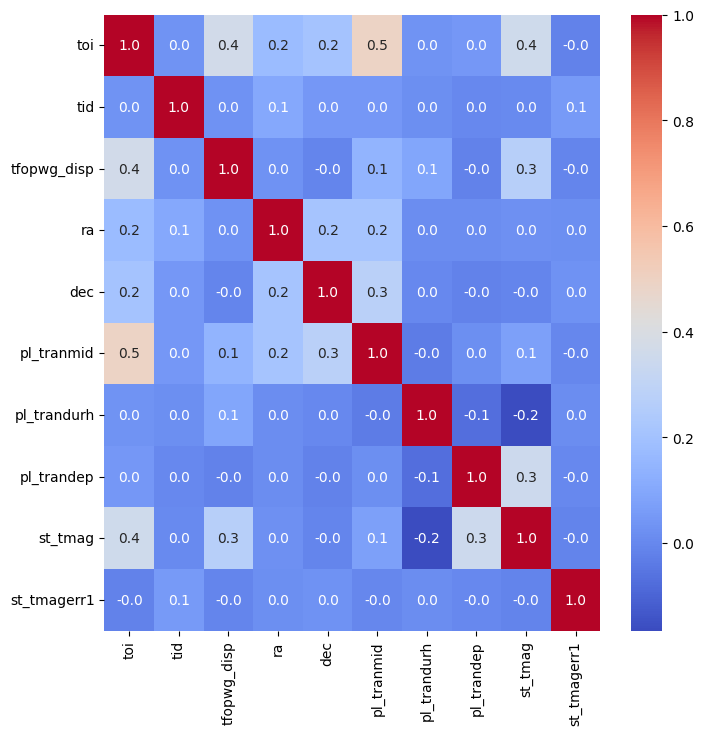

In [29]:
plt.figure(figsize=FIG_SIZE)
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.1f')

In [30]:
y = df[COLUMN_FOR_CLASSIFICATION]
X = df.drop(columns=[COLUMN_FOR_CLASSIFICATION], axis=1)

In [31]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7703 entries, 0 to 7702
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   toi          7703 non-null   float64
 1   tid          7703 non-null   int64  
 2   ra           7703 non-null   float64
 3   dec          7703 non-null   float64
 4   pl_tranmid   7703 non-null   float64
 5   pl_trandurh  7703 non-null   float64
 6   pl_trandep   7703 non-null   float64
 7   st_tmag      7703 non-null   float64
 8   st_tmagerr1  7703 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 541.7 KB


In [32]:
X.head()

,toi,tid,ra,dec,pl_tranmid,pl_trandurh,pl_trandep,st_tmag,st_tmagerr1
0,1000.01,50365310,112.357708,-12.695960,2.459230e+06,2.01722,656.886099,9.604000,0.013
1,1001.01,88863718,122.580465,-5.513852,2.459988e+06,3.16600,1286.000000,9.423440,0.006
2,1002.01,124709665,104.726966,-10.580455,2.459225e+06,1.40800,1500.000000,9.299501,0.058
3,1003.01,106997505,110.559945,-25.207017,2.458493e+06,3.16700,383.410000,9.300300,0.037
4,1004.01,238597883,122.178195,-48.802811,2.459987e+06,3.37000,755.000000,9.135500,0.006


In [33]:
X.tail()

,toi,tid,ra,dec,pl_tranmid,pl_trandurh,pl_trandep,st_tmag,st_tmagerr1
7698,995.01,317951248,110.811443,5.562850,2.458494e+06,2.572000,7260.750000,10.0781,0.007
7699,996.01,142918609,119.349948,-19.516015,2.458495e+06,6.826000,4040.000000,9.7925,0.006
7700,997.01,341729521,121.319521,-59.579798,2.459230e+06,3.556833,17479.605331,9.7727,0.006
7701,998.01,54390047,118.319555,-14.218823,2.459230e+06,1.360700,339.912662,9.6952,0.007
7702,999.01,341186896,118.864086,-58.222060,2.459986e+06,2.759000,1839.000000,9.6171,0.006


In [34]:
imputer = SimpleImputer(strategy='median')
imputed_features = imputer.fit_transform(X)
X = pd.DataFrame(imputed_features)

In [35]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)
X = pd.DataFrame(scaled_features)

In [36]:
# Split the resampled dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=RANDOM_STATE, shuffle=True, stratify=y
)

# Apply RandomOverSampler to balance the classes
ros = RandomOverSampler(random_state=RANDOM_STATE)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [37]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=RANDOM_STATE)
rf_clf.fit(X_train, y_train)

print(f'Training accuracy: {rf_clf.score(X_train, y_train) * 100:3.2f}%')
print(f'Testing accuracy: {rf_clf.score(X_test, y_test) * 100:3.2f}%')

Training accuracy: 100.00%
Testing accuracy: 68.59%


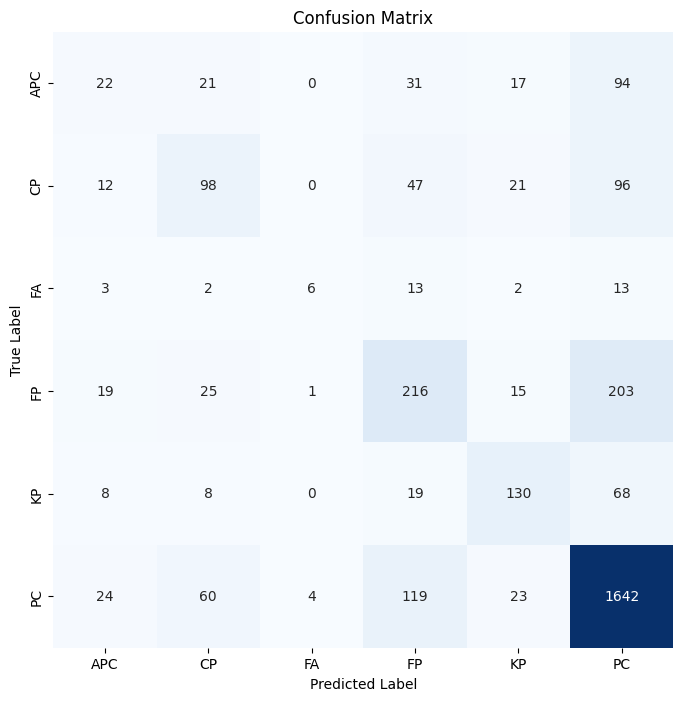

In [38]:
cf_matrix = confusion_matrix(y_test, rf_clf.predict(X_test))

plt.figure(figsize=FIG_SIZE)
sns.heatmap(
    cf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=False,
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

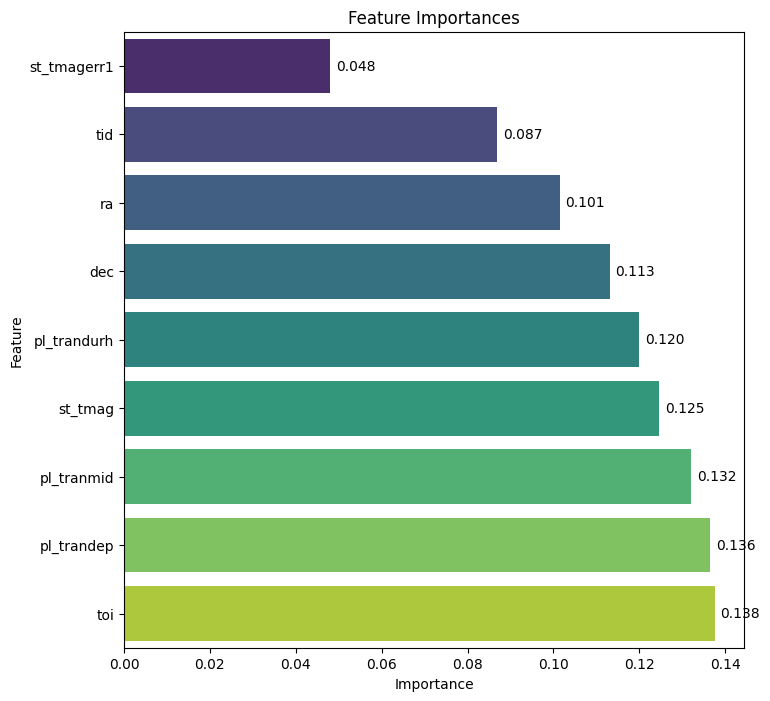

In [39]:
feature_names = df.drop(columns=[COLUMN_FOR_CLASSIFICATION]).columns.tolist()
importances = rf_clf.feature_importances_
feat_series = pd.Series(importances, index=feature_names).sort_values(ascending=True)

plt.figure(figsize=FIG_SIZE)
ax = sns.barplot(x=feat_series.values, y=feat_series.index, palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
for i, v in enumerate(feat_series.values):
    ax.text(v + max(feat_series.values) * 0.01, i, f'{v:.3f}', va='center')

plt.show()

In [40]:
os.makedirs('./models', exist_ok=True)

joblib.dump(rf_clf, './models/rf_toi.pkl')
joblib.dump(imputer, './models/imputer_toi.pkl')
joblib.dump(scaler, './models/scaler_toi.pkl')

['./models/scaler_toi.pkl']